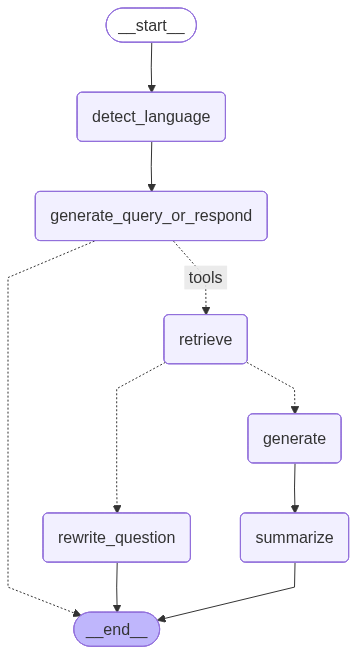

In [ ]:
import json, pandas as pd
from pathlib import Path
from datasets import Dataset
from ragas import evaluate
from ragas.metrics import faithfulness, answer_relevancy, context_precision, context_recall

import sys
import os
sys.path.append(os.path.join(os.getcwd(), '..'))

from src.agent.graph import build_graph, visualize_graph
from langgraph.checkpoint.memory import InMemorySaver  

checkpointer = InMemorySaver()
graph = build_graph(checkpointer=checkpointer)

from langchain_core.runnables import RunnableConfig

config: RunnableConfig = {
    "configurable": {
        "thread_id": 123 
    }
}

def rag(question: str):
    result = graph.invoke(
        {"messages": [{"role": "user", "content": question}]},
        config
    )
    return result

visualize_graph(graph)

In [10]:
import glob

# 특정 시나리오 파일 3개만 선택
scenario_files = ["data/scenario_c.jsonl", "data/scenario_e.jsonl", "data/scenario_g.jsonl"]

# DATASET_PATHS = sorted(glob.glob("data/scenario_*.jsonl"))
DATASET_PATHS = scenario_files
OUTDIR  = Path("results")

def load_gold_rows(paths: list[str]):
    rows = []
    for path in paths:
        print(f"Loading gold rows from {path}...")
        path = Path(path)
        with path.open("r", encoding="utf-8") as f:
            for line in f:
                if not line.strip():
                    continue
                item = json.loads(line)
                rows.append(item)
    return rows


gold = load_gold_rows(DATASET_PATHS)
print(f"Loaded {len(gold)} questions from {len(DATASET_PATHS)} files.")

Loading gold rows from data/scenario_c.jsonl...
Loading gold rows from data/scenario_e.jsonl...
Loading gold rows from data/scenario_g.jsonl...
Loaded 21 questions from 3 files.


In [11]:
# 1) 질문별로 agent 실행
preds = []
for item in gold:
    q  = item["question"]
    gt = item["ground_truth"] 
    r  = rag(q)               
    ctxs = r.get("documents", [])
    ans = r.get("messages", [])[-1].content
    preds.append({
        "question": q,
        "answer": ans,
        "contexts": ctxs,
        "ground_truth": gt,
    })
    print("processed question:", q)

# 2) HuggingFace Dataset 변환
df = pd.DataFrame(preds)
ds = Dataset.from_pandas(df)

print("Evaluation starting...")
# 3) RAGAS 메트릭 계산
result = evaluate(
    ds,
    metrics=[faithfulness, answer_relevancy, context_precision, context_recall],
)

result_df = result.to_pandas()
display(result_df)

import datetime
current_time = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
# Calculate mean scores for each metric
result_df['faithfulness_mean'] = result_df['faithfulness'].mean()
result_df['answer_relevancy_mean'] = result_df['answer_relevancy'].mean()
result_df['context_precision_mean'] = result_df['context_precision'].mean()
result_df['context_recall_mean'] = result_df['context_recall'].mean()

csv_filename = f"{current_time}.csv"
csv_path = OUTDIR / csv_filename
result_df.to_csv(csv_path, index=False, encoding='utf-8')
print(f"Results saved to: {csv_path}")

: 